### Визуализация работы CNN

In [2]:
from keras.models import load_model

In [4]:
model = load_model('cats_and_dogs_small_2.h5')

In [5]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)      

In [10]:
img_path = 'C:/DataSets/dogs-vs-cats_small/test/cats/cat.1505.jpg'

In [7]:
from keras.preprocessing import image
import numpy as np

In [11]:
img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor/=255.

In [12]:
img_tensor.shape

(1, 150, 150, 3)

In [13]:
import matplotlib.pyplot as plt

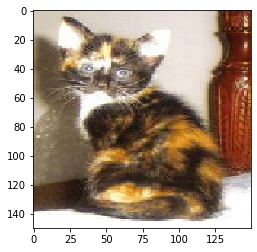

In [14]:
plt.imshow(img_tensor[0])
plt.show()

In [15]:
from keras import models

In [16]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [17]:
activations = activation_model.predict(img_tensor)

In [18]:
first_layer_activations = activations[0]
first_layer_activations.shape

(1, 148, 148, 32)

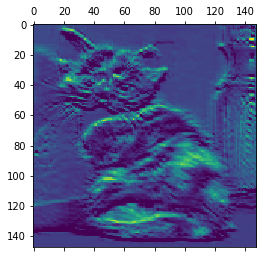

In [32]:
plt.matshow(first_layer_activations[0, :, :, 2], cmap='viridis')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


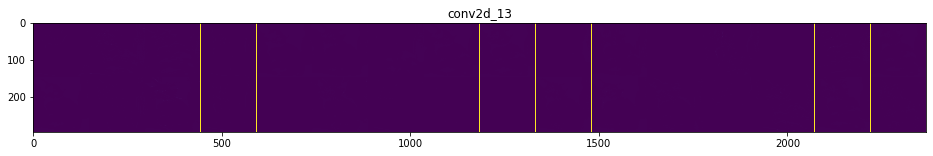

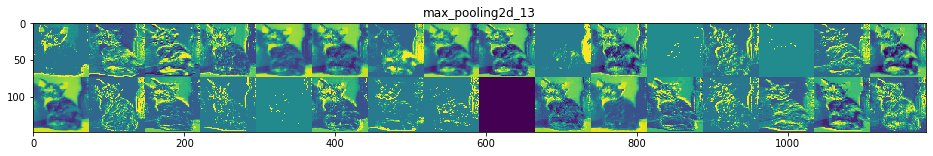

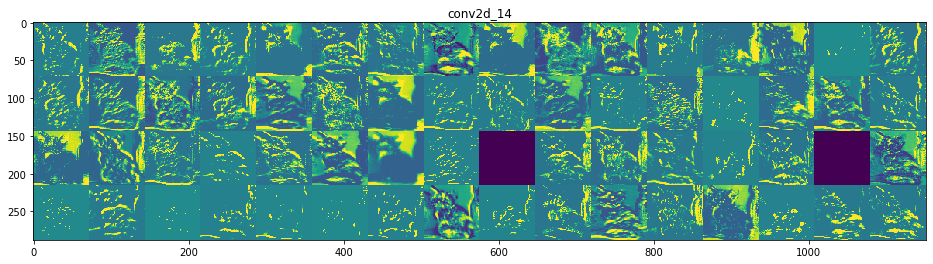

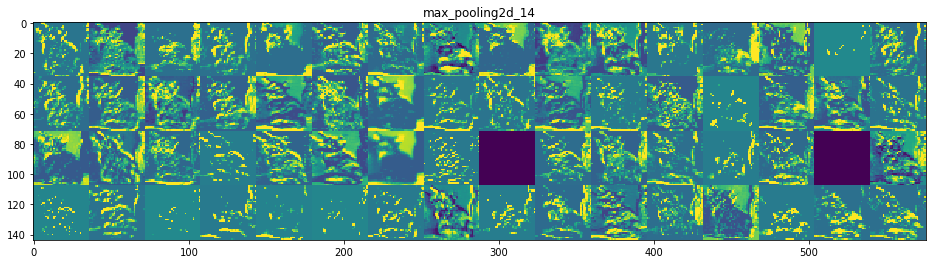

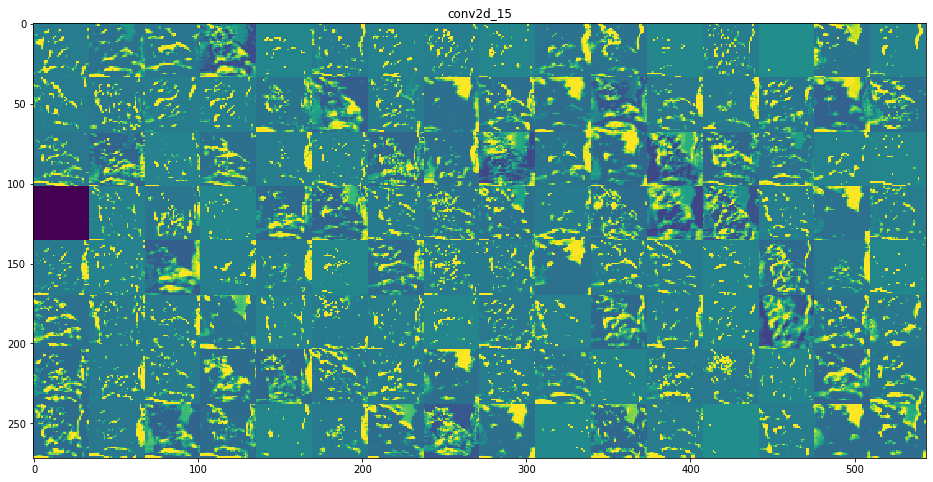

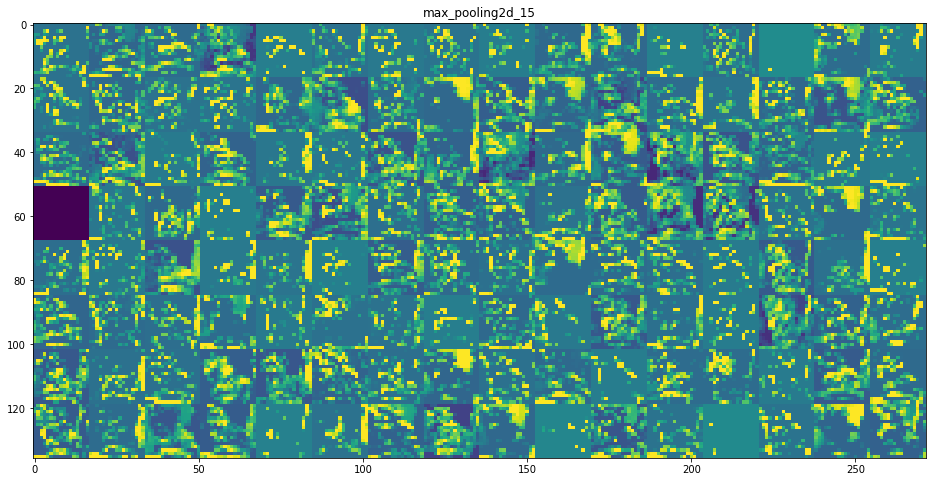

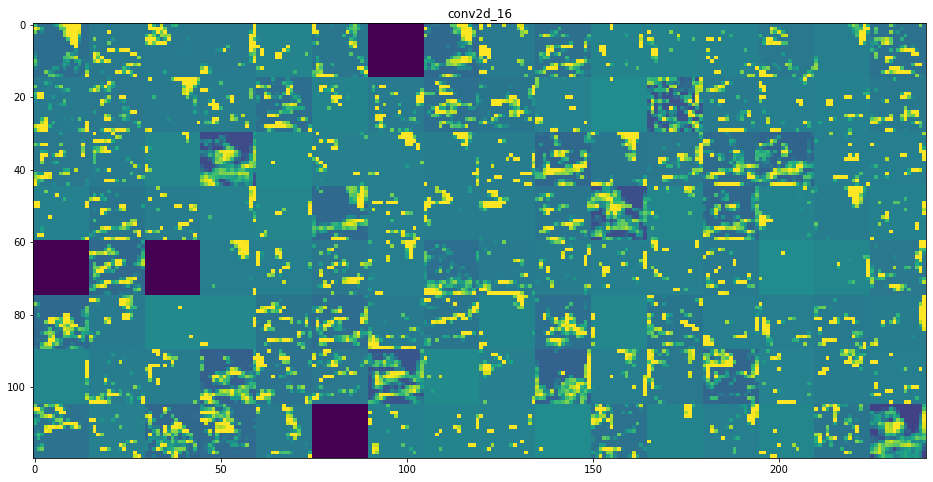

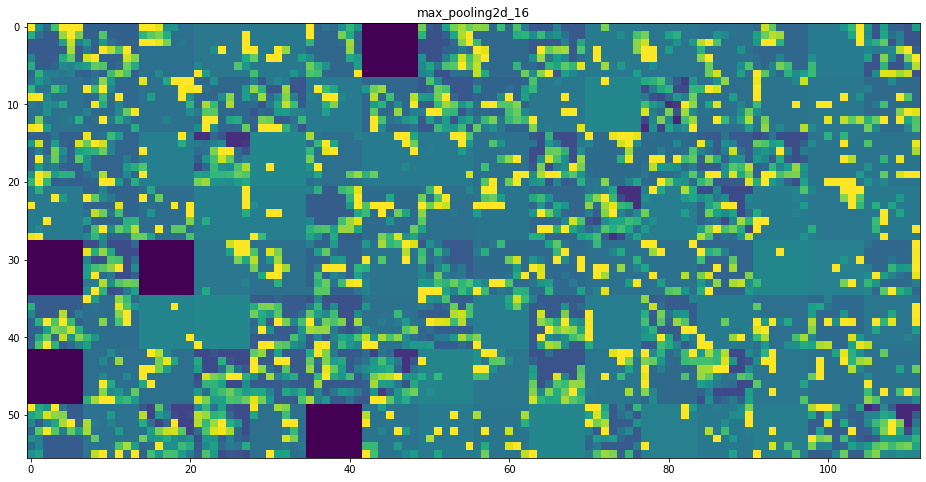

In [39]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features//images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*image_per_row+row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size : (col+1)*size,
                        row*size : (row+1)*size] = channel_image
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1],
                       scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Визуализация фильтров сверточных нейронных сетей

In [12]:
from keras.applications import VGG16
from keras import backend as K

In [2]:
model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:,filter_index])

In [4]:
grads = K.gradients(loss, model.input)[0]

#### Нормализация градиента (PogChamp)

In [5]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [6]:
iterate = K.function([model.input], [loss, grads])

In [7]:
import numpy as np

In [8]:
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

#### Далее используется градиентный спуск чтобы МАКСИМИЗИРОВАТЬ функцию потерь для получения картинки с максимальным откликом фильтра

In [9]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

In [10]:
step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [11]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

#### Объединим все в одну функцию генерации изображения, которое представляет фильтр

In [32]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

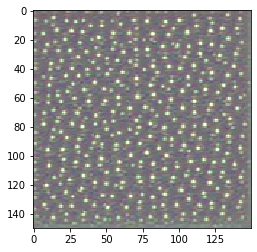

In [33]:
plt.imshow(generate_pattern('block3_conv1', 0))

#### Сетки с шаблонами откликов фильтров в слоях

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


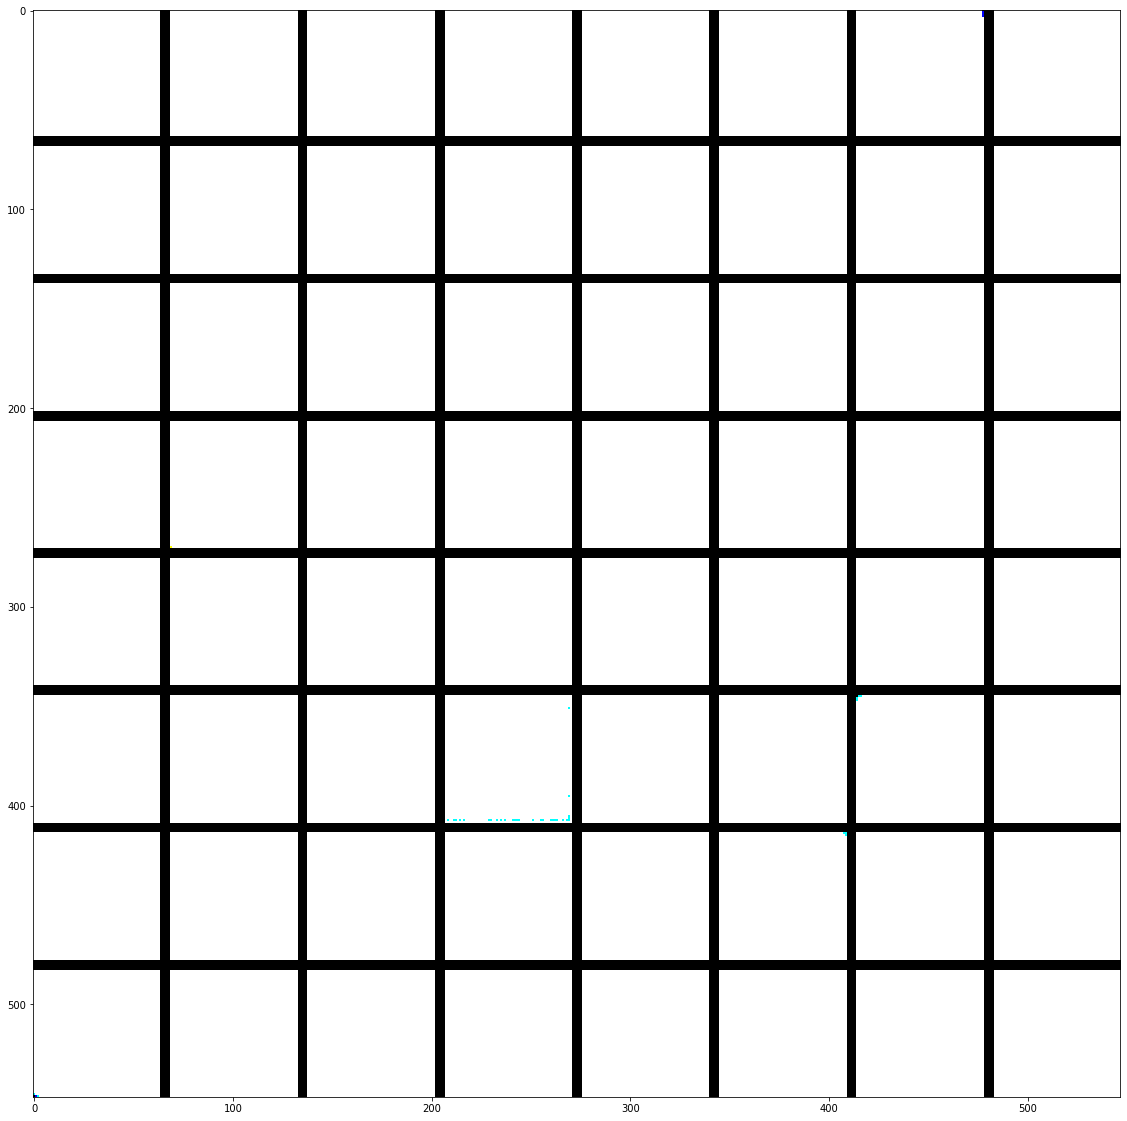

In [34]:
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8*size + 7*margin, 8*size + 7*margin, 3))
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j*8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results)

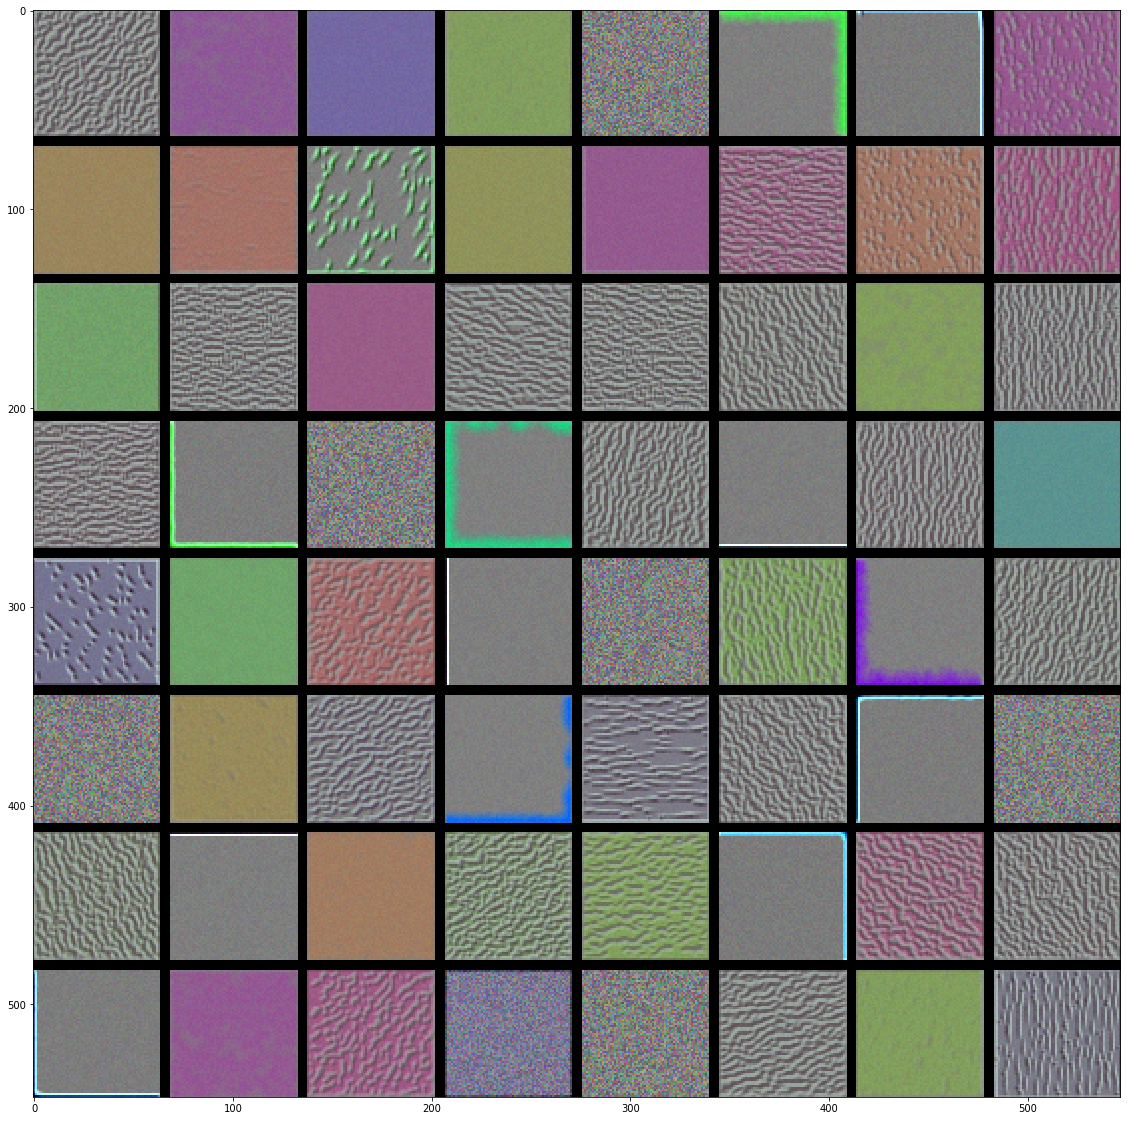

In [38]:
plt.figure(figsize=(20,20))
plt.imshow(results.astype('int'))

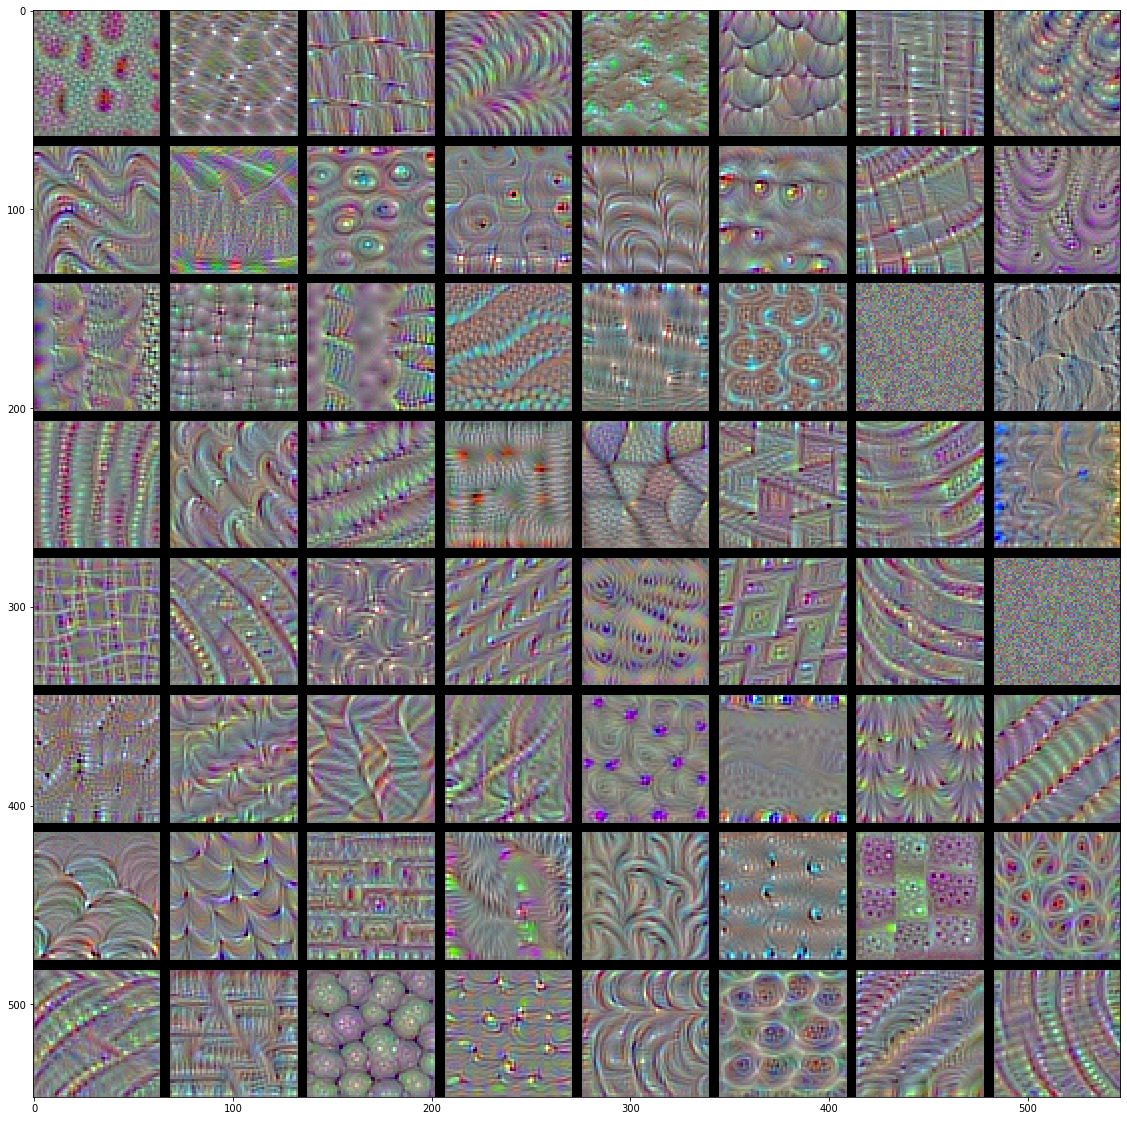

In [39]:
layer_name = 'block4_conv1'
size = 64
margin = 5

results = np.zeros((8*size + 7*margin, 8*size + 7*margin, 3))
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j*8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results.astype('int'))

# Тепловые карты активации класса

In [1]:
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [2]:
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 952s 2us/step


In [4]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [5]:
img = image.load_img('dog.1515.jpg', target_size = (224,224))

In [6]:
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = preprocess_input(x)

In [7]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02106662', 'German_shepherd', 0.86208236), ('n02105162', 'malinois', 0.077538736), ('n02091467', 'Norwegian_elkhound', 0.055368483)]


In [8]:
np.argmax(preds[0])

235

### Grad-CAM

In [15]:
german_shepherd_output = model.output[:235]
last_conv_layer = model.get_layer('block5_conv3')

In [16]:
grads = K.gradients(german_shepherd_output, last_conv_layers.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2))

In [18]:
iterate = K.function([model.input],
                    [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [21]:
import matplotlib.pyplot as plt

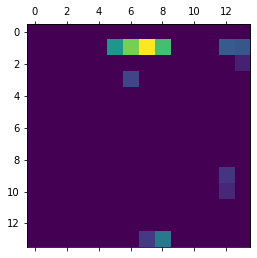

In [22]:
heatmap = np.maximum(heatmap,0)
heatmap/=np.max(heatmap)
plt.matshow(heatmap)

In [27]:
#!python -m pip install opencv-python

In [28]:
import cv2

In [29]:
img = cv2.imread('dog.1515.jpg')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('heatmap.jpg', superimposed_img)

True